### Supporting Information for _Linear mixed model for heritability estimation that explicitly addresses environmental variation_

> Version 0.4.8

> September 20, 2020


This IPython notebook is supplement to [Heckerman, et al. PNAS 2016](http://www.pnas.org/content/113/27/7377.abstract). (Also, you can [watch the platform presentation](https://youtu.be/Xacer-IJXbI) of this work at ASHG 2015 via YouTube).

This notebook generates synthetic data and illustrates the application of our code to that data.  It allows you to run these analyses on your computer, easily experimenting with different data-generation parameters. If you would like to do this, you need to:

* Install Python and FaST-LMM on your computer as described in [FaST-LMM's README.md](https://github.com/fastlmm/FaST-LMM/blob/master/README.md)
* Download this IPython notebook from https://github.com/fastlmm/FaST-LMM/blob/master/doc/ipynb/heritability_si.ipynb
* Start the IPython notebook from the command line by typing "ipython notebook" and then opening the downloaded notebook. (You can find general information about using IPython notebooks [here](http://jupyter-notebook-beginner-guide.readthedocs.org/en/latest/execute.html).)

#### Documentation and Contacts

* See [FaST-LMM's README.md](https://github.com/fastlmm/FaST-LMM/blob/master/README.md) for documentation and code.
* Email the developers at fastlmm-dev@python.org.
* [Join](mailto:fastlmm-user-join@python.org?subject=Subscribe) the user discussion and announcement list (or use [web sign up](https://mail.python.org/mailman3/lists/fastlmm-user.python.org)).
* [Open an issue](https://github.com/fastlmm/FaST-LMM/issues) on GitHub.

## Preparing the Python Environment and Notebook

Uncomment and run this cell only if these packages need to be install or updated.

In [1]:
# #Main package
# !pip install fastlmm">="0.3.0

To prepare this notebook to run analyses, please run the following script.  

In [1]:
# set some ipython notebook properties
%matplotlib inline

# set degree of verbosity (adapt to INFO for more verbose output or debug for info more)
import logging
logging.basicConfig(level=logging.INFO)

# set figure sizes
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# set display width for pandas data frames
import pandas as pd
pd.set_option('display.width', 1000)

# supress warnings
import warnings
warnings.filterwarnings('ignore')

## Data Generation

To generate the data, we create SNPs and geo-spatial locations.  We then generate the phenotype from these SNPs and geo-spatial locations. Note that, because the data is synthetic, we know the causal SNPs.  Consequently, we use ${\bf \rm K_{causal}}$ rather than its approximation, ${\bf \rm K_{IBD}}$, in this analysis.

First, we generate 1000 SNPs per individual for 5000 individuals using the Balding-Nichols model for two populations with an FST of 0.1. The heatmap shows the resulting similarity matrix, ${\bf \rm K_{causal}}$, highlighting the existence of two populations.

INFO:root:Simulating SNPs from a population 0
INFO:root:Simulating SNPs from a population 1


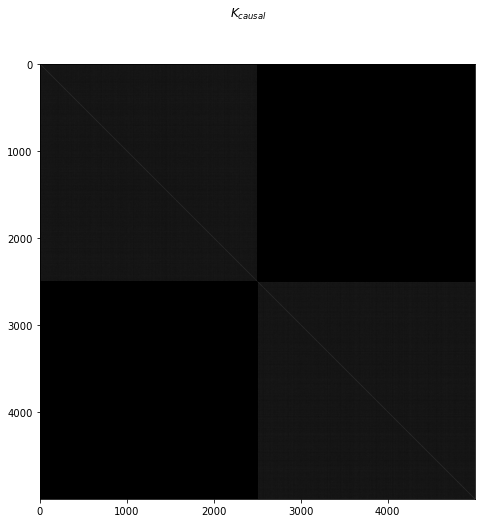

In [2]:
from pysnptools.util import snp_gen
from pysnptools.standardizer import Unit

seed = 0
N = 5000

#Generate SNPs
snpdata = snp_gen(fst=.1, dfr=0, iid_count=N, sid_count=1000, chr_count=10, label_with_pop=True,seed=seed)
K_causal = snpdata.read_kernel(Unit()).standardize()

pylab.rcParams['figure.figsize'] = (10.0, 8.0)
pylab.suptitle("$K_{causal}$")
pylab.imshow(K_causal.val, cmap=pylab.gray(), vmin=0, vmax=1)
pylab.show()

Next, we generate a geo-spatial location for each individual by sampling from a two-dimensional Gaussian distribution whose center depends on which population the individual is from.  This creates a correlation between the SNPs and geo-spatial location.

The plot shows the position of each individual. The two colors reflect the two populations.

INFO:root:Generating positions for seed 0


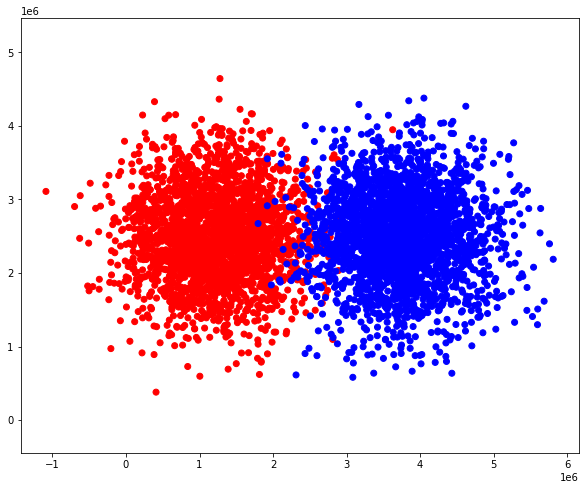

In [3]:
import numpy as np
from pysnptools.snpreader import SnpData

distance_between_centers = 2500000
x0 = distance_between_centers * 0.5
x1 = distance_between_centers * 1.5
y0 = distance_between_centers
y1 = distance_between_centers
sd = distance_between_centers/4.

spatial_iid = snpdata.iid
center_dict = {"0": (x0,y0), "1": (x1,y1)}
centers = np.array([center_dict[iid_item[0]] for iid_item in spatial_iid])
np.random.seed(seed)
logging.info("Generating positions for seed {0}".format(seed))
spatial_coor_gen_original = SnpData(iid=snpdata.iid,sid=["x","y"],val=centers+np.random.multivariate_normal([0,0],[[1,0],[0,1]],size=len(centers))*sd,parent_string="'spatial_coor_gen_original'")

import matplotlib.pyplot as plt
color_dict = {"0": "r", "1": "b", "2": "g"}
colors = [color_dict[iid_item] for iid_item in snpdata.iid[:,0]]
plt.axis('equal')
plt.scatter(spatial_coor_gen_original.val[:,0], spatial_coor_gen_original.val[:,1], c=colors)
plt.show()

Below is the the similarity matrix ${\rm \bf K}_{\rm loc}$ based on these locations and parameter alpha. ${\rm \bf K}_{{\rm loc}\ {ij}}={\rm exp}(-({\rm distance}(i,j)/\alpha)^2)$.

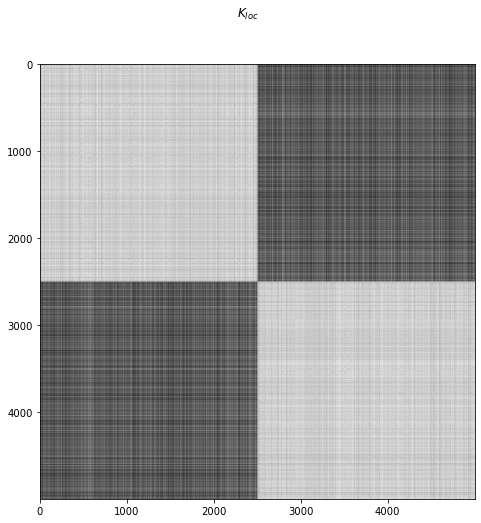

In [4]:
from fastlmm.association.heritability_spatial_correction import spatial_similarity
from pysnptools.kernelreader import KernelData

alpha = distance_between_centers
spatial_val = spatial_similarity(spatial_coor_gen_original.val, alpha, power=2)
K_loc = KernelData(iid=snpdata.iid,val=spatial_val).standardize()

pylab.suptitle("$K_{loc}$")
pylab.imshow(K_loc.val, cmap=pylab.gray(), vmin=0, vmax=1)
pylab.show()

Finally, we generate the phenotype ${\rm \bf y}$ by sampling from the mixed model ${\rm \bf y} \sim {\bf N}({\bf \mu}; σ_g^2 \  {\bf \rm K_{causal}} + σ_e^2 \ {\bf \rm K_{loc}} + σ_r^2 {\bf \rm I})$ with  ${\bf \mu} = 0$ and $ σ_g^2=σ_e^2=σ_r^2=1$. Rather than draw a sample from this distribution directly, we equivalently draw a sample from each variant component separately and then add them, so that we can optionally permute the sample from the spatial component in order to break the dependence between SNPs and location.

pop0 mean=1.368830555580309. pop1 mean=1.1199768387606164


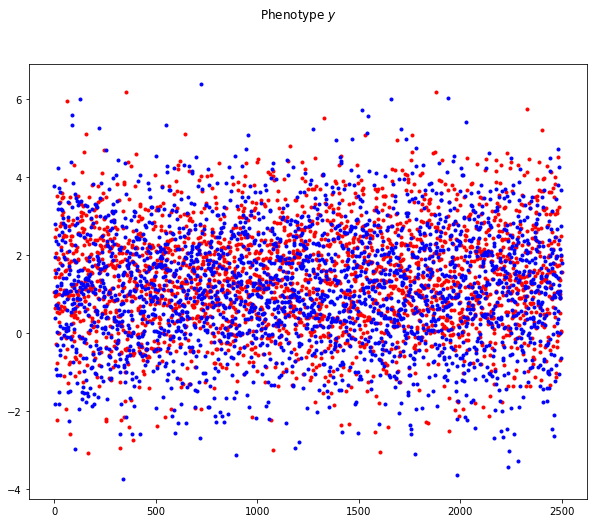

In [5]:
from pysnptools.snpreader import SnpData

iid = K_causal.iid
iid_count = K_causal.iid_count
np.random.seed(seed)
pheno_causal = SnpData(iid=iid,sid=["causal"],val=np.random.multivariate_normal(np.zeros(iid_count),K_causal.val).reshape(-1,1),parent_string="causal")
np.random.seed(seed^998372)
pheno_noise = SnpData(iid=iid,sid=["noise"],val=np.random.normal(size=iid_count).reshape(-1,1),parent_string="noise")
np.random.seed(seed^12230302)
pheno_loc_original = SnpData(iid=iid,sid=["loc_original"],val=np.random.multivariate_normal(np.zeros(iid_count),K_loc.val).reshape(-1,1),parent_string="loc_original")

do_shuffle = False
if do_shuffle:
    idx = np.arange(iid_count)
    np.random.seed(seed)
    np.random.shuffle(idx)
    pheno_loc = pheno_loc_original.read(view_ok=True) #don't need to copy, because the next line will be fresh memory
    pheno_loc.val = pheno_loc.val[idx,:]
else:
    pheno_loc = pheno_loc_original
                       
pheno = SnpData(iid=iid,sid=["pheno_all"],val=pheno_causal.val+pheno_noise.val+pheno_loc.val)

is_pop0 = snpdata.iid[:,0]=="0"
is_pop1 = snpdata.iid[:,0]=="1"
print("pop0 mean={0}. pop1 mean={1}".format(pheno.val[is_pop0].mean(),pheno.val[is_pop1].mean()))
pylab.suptitle("Phenotype $y$")
plt.plot(range(sum(is_pop0)),pheno.val[is_pop0],"r.",range(sum(is_pop1)),pheno.val[is_pop1],"b.")
plt.show()

## Analysis

Now let us estimate heritabilities using our methodology. The method takes as input  ${\rm \bf K}_{\rm causal}$, geo-spatial location, and phenotype. It searches for the best $\alpha$ and then estimates $σ_g^2, σ_e^2, σ_r^2$ using REML. The Python function that performs the analysis is called 'heritability_spatial_correction'.

Here we loop over multiple random seeds in order to generate and analyze multiple data sets. Python function 'loop_generate_and_analyze' does the looping. It calls 'generate_and_analyze' which generates the data for each seed and calls 'heritability_spatial_correction' to analyze the data.

In [6]:
from pysnptools.util import snp_gen
from pysnptools.standardizer import Unit
import numpy as np
from fastlmm.association.heritability_spatial_correction import spatial_similarity
from pysnptools.kernelreader import KernelData
from pysnptools.snpreader import SnpData
from fastlmm.association import heritability_spatial_correction

def generate_and_analyze(seed, N, do_shuffle, just_testing=True, map_function=None, cache_folder=None):

    #Generate SNPs
    snpdata = snp_gen(fst=.1, dfr=0, iid_count=N, sid_count=1000, chr_count=10, label_with_pop=True,seed=seed)
    K_causal = snpdata.read_kernel(Unit()).standardize()

    #Generate geo-spatial locations and K_loc
    distance_between_centers = 2500000
    x0 = distance_between_centers * 0.5
    x1 = distance_between_centers * 1.5
    y0 = distance_between_centers
    y1 = distance_between_centers
    sd = distance_between_centers/4.

    spatial_iid = snpdata.iid
    center_dict = {"0": (x0,y0), "1": (x1,y1)}
    centers = np.array([center_dict[iid_item[0]] for iid_item in spatial_iid])
    np.random.seed(seed)
    logging.info("Generating positions for seed {0}".format(seed))
    spatial_coor = SnpData(iid=snpdata.iid,sid=["x","y"],val=centers+np.random.multivariate_normal([0,0],[[1,0],[0,1]],size=len(centers))*sd,parent_string="'spatial_coor_gen_original'")
    alpha = distance_between_centers
    spatial_val = spatial_similarity(spatial_coor.val, alpha, power=2)
    K_loc = KernelData(iid=snpdata.iid,val=spatial_val).standardize()

    #Generate phenotype
    iid = K_causal.iid
    iid_count = K_causal.iid_count
    np.random.seed(seed)
    pheno_causal = SnpData(iid=iid,sid=["causal"],val=np.random.multivariate_normal(np.zeros(iid_count),K_causal.val).reshape(-1,1),parent_string="causal")
    np.random.seed(seed^998372)
    pheno_noise = SnpData(iid=iid,sid=["noise"],val=np.random.normal(size=iid_count).reshape(-1,1),parent_string="noise")
    np.random.seed(seed^12230302)
    pheno_loc_original = SnpData(iid=iid,sid=["loc_original"],val=np.random.multivariate_normal(np.zeros(iid_count),K_loc.val).reshape(-1,1),parent_string="loc_original")

    if do_shuffle:
        idx = np.arange(iid_count)
        np.random.seed(seed)
        np.random.shuffle(idx)
        pheno_loc = pheno_loc_original.read(view_ok=True) #don't need to copy, because the next line will be fresh memory
        pheno_loc.val = pheno_loc.val[idx,:]
    else:
        pheno_loc = pheno_loc_original

    pheno = SnpData(iid=iid,sid=["pheno_all"],val=pheno_causal.val+pheno_noise.val+pheno_loc.val)

    #Analyze data
    alpha_list = [int(v) for v in np.logspace(np.log10(100),np.log10(1e10), 100)]
    dataframe = heritability_spatial_correction(
        snpdata,
        spatial_coor.val,spatial_iid,
        alpha_list=[alpha] if just_testing else alpha_list,pheno=pheno, alpha_power=2,
        jackknife_count=0,permute_plus_count=0,permute_times_count=0,just_testing=just_testing,
        map_function=map_function,cache_folder=cache_folder)

    logging.info(dataframe)
    return dataframe

def loop_generate_and_analyze(N, seed_count, do_shuffle, just_testing, map_function, cache_folder=None):
    '''
    run generate_and_analyze on different seeds
    '''
    df_list = []
    for seed in range(seed_count):
        if cache_folder is not None:
            cache_folder_per_seed = cache_folder.format(seed)
        else:
            cache_folder_per_seed = None
        df = generate_and_analyze(seed=seed,N=N,do_shuffle=do_shuffle,
                           just_testing=just_testing, map_function=map_function, cache_folder=cache_folder_per_seed)
        df_list.append(df)
        
    #format the output dataframe            
    df2 = pd.concat(df_list)
    df2["seed"] = range(seed_count)
    df2["N"]=N
    df2["do_shuffle"]=do_shuffle
    df3 = df2[["seed","N","do_shuffle", "alpha","h2corr","e2","h2uncorr"]]
    df3.set_index(["seed"],inplace=True)
    return df3

#### Test Run

To test 'loop_generate_and_analyze', we'll run it first locally with 'N=100' and 'just_testing=True'. With these settings, it should return in just a few seconds, but without meaningful results. At the very bottom of this notebook, you'll additional tests (that take about 20 minutes each to run).

In [7]:
logging.getLogger().setLevel(logging.WARN)
df = loop_generate_and_analyze(N=100,seed_count=7,do_shuffle=True,just_testing=True,map_function=map)
df

,N,do_shuffle,alpha,h2corr,e2,h2uncorr
seed,,,,,,
0,100,True,2500000,0,0,0
1,100,True,2500000,0,0,0
2,100,True,2500000,0,0,0
3,100,True,2500000,0,0,0
4,100,True,2500000,0,0,0
5,100,True,2500000,0,0,0
6,100,True,2500000,0,0,0


#### Full Run

The full run with 5000 individuals and 7 datasets requires a cluster. Here we use HPC cluster (Azure or private), but any cluster that can mimic Python's 'map' function may be used. Even with a cluster, the run can take a long time.  If you’d like to get a result more quickly, you could (e.g.) set N=500 and generate fewer datasets.

In [8]:
#Define a version of 'map' in terms of a cluster
from fastlmm.association.heritability_spatial_correction import work_item
#from pysnptools.util.mapreduce1.runner import HPC
from pysnptools.util.mapreduce1.runner import LocalMultiProc,Local

#azure_runner_function = lambda taskcount: HPC(min(taskcount,10100), 'GCR',r"\\GCR\Scratch\AZ-USCentral\escience",
#                                        remote_python_parent=r"\\GCR\Scratch\AZ-USCentral\escience\carlk\data\carlk\pythonpath",
#                                        unit='Core', #Core, Socket, Node
#                                        update_remote_python_parent=True,
#                                        template="Azure IaaS USCentral",
#                                        runtime="0:8:0",
#                                        mkl_num_threads=1                                                 
#                                        )

#msr_core_runner_function = lambda taskcount: HPC(min(taskcount,10100), 'GCR',r"\\GCR\Scratch\B99\escience",
#                                            remote_python_parent=r"\\GCR\Scratch\B99\escience\carlk\data\carlk\pythonpath",
#                                            unit='node', #core, socket, node
#                                            update_remote_python_parent=True,
#                                            template="ExpressQ",
#                                            priority="Normal",
#                                            runtime="0:4:0", # day:hour:min
#                                            )
runner_function = lambda taskcount: LocalMultiProc(min(taskcount,5))
#runner_function = lambda taskcount: Local()


from pysnptools.util.mapreduce1 import map_reduce
map_function = (lambda ignore, arg_list, runner_function=runner_function, fn_list=[] :
                   map_reduce(arg_list,work_item,runner=runner_function(len(arg_list))))

#Generate data and analyze it.
N=5000
seed_count=1
do_shuffle=False
cache_pattern=r"D:\data\synth\N{0}\seed{1}".format(N,"{0}")

if False: #set this to True to actually run
    df = loop_generate_and_analyze(N=N,seed_count=seed_count,do_shuffle=do_shuffle,just_testing=False,
                            map_function=map_function,
                            cache_folder=cache_pattern
                                  )
    df

Here are the outputs for 50 seeds.

<table border="1" cellpadding="0" cellspacing="0" width="485" style="border-collapse: collapse; width: 365pt" bordercolor="#000000">
	<colgroup>
		<col width="64" span="4" style="width:48pt">
		<col width="74" span="2" style="width: 56pt">
		<col width="81" style="width: 61pt">
	</colgroup>
	<tr height="20" style="height:15.0pt">
		<td height="20" width="64" style="height: 15.0pt; width: 48pt; font-weight: 700; color: black; font-size: 11.0pt; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">seed</td>
		<td width="64" style="width: 48pt; font-weight: 700; color: black; font-size: 11.0pt; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">N</td>
		<td width="64" style="width: 48pt; font-weight: 700; color: black; font-size: 11.0pt; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">do_shuffle</td>
		<td width="64" style="width: 48pt; font-weight: 700; color: black; font-size: 11.0pt; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">alpha</td>
		<td width="74" style="width: 56pt; font-weight: 700; color: black; font-size: 11.0pt; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">h2corr</td>
		<td width="74" style="width: 56pt; font-weight: 700; color: black; font-size: 11.0pt; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">e2</td>
		<td width="81" style="width: 61pt; font-weight: 700; color: black; font-size: 11.0pt; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">h2uncorr</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.308</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.399</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.456</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">1</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.201</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.586</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.408</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.399</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.198</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.477</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">3</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">3351602</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.273</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.465</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.465</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">4</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.367</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.242</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.460</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.396</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.237</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.473</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">6</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.332</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.331</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.431</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">7</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">3351602</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.393</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.208</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.482</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">8</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.391</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.211</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.461</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">9</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.380</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.267</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.495</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">10</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.201</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.564</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.431</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">11</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.292</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.439</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.455</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">12</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.303</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.423</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.469</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">13</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.199</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.582</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.386</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">14</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.405</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.177</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.474</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">15</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.377</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.264</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.488</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">16</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.438</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.110</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.469</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">17</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.293</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.433</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.458</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">18</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.337</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.342</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.452</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">19</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">1917910</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.373</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.258</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.450</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">20</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.359</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.272</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.459</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">21</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.380</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.230</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.453</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">22</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.342</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.363</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.482</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">23</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.273</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.442</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.428</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">24</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.326</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.359</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.465</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">25</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.352</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.319</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.484</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">26</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.336</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.303</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.421</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">27</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">4037017</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.364</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.297</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.507</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">28</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.302</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.376</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.407</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">29</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.259</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.503</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.477</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">30</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">1321941</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.470</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.063</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.492</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">31</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.322</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.354</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.451</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">32</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.256</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.481</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.430</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">33</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.289</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.398</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.412</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">34</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.357</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.268</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.476</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">35</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.314</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.398</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.440</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">36</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.371</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.280</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.492</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">37</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.293</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.419</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.405</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">38</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.285</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.435</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.444</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">39</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.344</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.314</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.474</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">40</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.263</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.479</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.452</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">41</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.253</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.492</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.411</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">42</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.235</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.515</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.422</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">43</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.318</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.355</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.431</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">44</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.353</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.327</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.487</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">45</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">3351602</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.247</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.504</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.463</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">46</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.412</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.206</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.501</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">47</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.287</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.404</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.450</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">48</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.396</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.259</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.491</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">49</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">FALSE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.359</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.280</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px" bordercolor="#000000">
		<p style="white-space: normal">0.471</td>
	</tr>
</table>


The mean (± SE) of h2corr, e2, and h2uncorr are 0.33±0.01, 0.35±0.02, and 0.46±0.01, respectively.

Here are the outputs for the same 50 seeds with doShuffle=true, which breaks the dependence between SNPs and location.

<table border="1" cellpadding="0" cellspacing="0" width="430" style="border-collapse: collapse; width: 324pt" bordercolor="#000000">
	<colgroup>
		<col width="53" style="width: 40pt"><col width="60" style="width: 45pt">
		<col width="85" style="width: 64pt"><col width="70" style="width: 53pt">
		<col width="48" span="2" style="width: 36pt">
		<col width="66" style="width: 50pt">
	</colgroup>
	<tr height="20" style="height:15.0pt">
		<td height="20" width="53" style="height: 15.0pt; width: 40pt; font-weight: 700; color: black; font-size: 11.0pt; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		seed</td>
		<td width="60" style="width: 45pt; font-weight: 700; color: black; font-size: 11.0pt; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		N</td>
		<td width="85" style="width: 64pt; font-weight: 700; color: black; font-size: 11.0pt; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		do_shuffle</td>
		<td width="70" style="width: 53pt; font-weight: 700; color: black; font-size: 11.0pt; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		alpha</td>
		<td width="48" style="width: 36pt; font-weight: 700; color: black; font-size: 11.0pt; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		h2corr</td>
		<td width="48" style="width: 36pt; font-weight: 700; color: black; font-size: 11.0pt; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		e2</td>
		<td width="66" style="width: 50pt; font-weight: 700; color: black; font-size: 11.0pt; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		h2uncorr</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.275</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.465</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.382</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		1</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.282</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.421</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.382</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.396</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.203</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.465</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		3</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.344</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.323</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.353</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		4</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		1917910</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.407</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.157</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.450</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.386</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.256</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.463</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		6</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		3351602</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.181</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.634</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.438</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		7</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.438</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.120</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.446</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		8</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		1917910</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.444</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.101</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.460</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		9</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.301</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.418</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.411</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		10</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		1917910</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.318</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.309</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.414</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		11</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.315</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.395</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.359</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		12</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.314</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.400</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.460</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		13</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.222</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.533</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.393</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		14</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		1917910</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.399</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.187</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.476</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		15</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.280</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.453</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.468</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		16</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.433</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.119</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.468</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		17</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.311</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.398</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.390</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		18</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.297</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.421</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.385</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		19</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.312</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.379</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.458</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		20</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.354</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.282</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.447</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		21</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.390</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.209</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.418</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		22</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.277</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.485</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.337</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		23</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.277</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.435</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.425</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		24</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.356</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.299</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.436</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		25</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.402</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.224</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.473</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		26</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		1917910</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.352</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.271</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.351</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		27</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		4862601</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.316</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.388</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.491</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		28</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.251</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.479</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.365</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		29</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.299</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.427</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.477</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		30</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		1592282</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.474</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.056</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.491</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		31</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.276</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.447</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.413</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		32</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.266</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.460</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.348</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		33</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.326</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.322</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.426</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		34</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		3351602</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.309</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.368</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.476</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		35</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.246</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.527</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.332</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		36</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.421</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.184</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.482</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		37</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.275</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.454</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.400</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		38</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.269</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.468</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.401</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		39</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.363</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.275</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.448</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		40</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.342</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.324</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.451</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		41</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.273</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.450</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.311</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		42</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.300</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.381</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.301</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		43</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.288</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.417</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.423</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		44</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.377</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.281</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.383</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		45</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.320</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.358</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.461</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		46</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.441</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.150</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.464</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		47</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		3351602</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.258</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.465</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.350</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		48</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2310129</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.394</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.262</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.458</td>
	</tr>
	<tr height="20" style="height:15.0pt">
		<td height="20" align="right" style="height: 15.0pt; color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		49</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		5000</td>
		<td align="center" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		TRUE</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		2782559</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.303</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.395</td>
		<td align="right" style="color: black; font-size: 11.0pt; font-weight: 400; font-style: normal; text-decoration: none; font-family: Calibri, sans-serif; text-align: general; vertical-align: bottom; white-space: nowrap; border: 1px solid; padding-left: 1px; padding-right: 1px; padding-top: 1px">
		0.421</td>
	</tr>
</table>




The mean (± SE) of h2corr, e2, and h2uncorr are 0.33±0.01, 0.35±0.02, and 0.42±0.01, respectively.

Note that the values of h2corr and e2 are consistent with the generating parameters. Also note that h2uncorr is larger than h2corr for 99 of the 100 rows.

#### Additional Testing

In [9]:
#Runs in about 1 minute
logging.getLogger().setLevel(logging.WARN)
df = loop_generate_and_analyze(N=50,seed_count=1,do_shuffle=True,just_testing=False,map_function=map)
df

,N,do_shuffle,alpha,h2corr,e2,h2uncorr
seed,,,,,,
0,50,True,170735,0.391851,0.608139,0.429533


In [10]:
#Runs in about 3 minutes
logging.getLogger().setLevel(logging.WARN)
df = loop_generate_and_analyze(N=50,seed_count=1,do_shuffle=False,just_testing=False,map_function=map)
df

,N,do_shuffle,alpha,h2corr,e2,h2uncorr
seed,,,,,,
0,50,False,141747,0.01437,0.98562,0.0


In [11]:
#Runs in about 4 minutes
logging.getLogger().setLevel(logging.WARN)

from pysnptools.util.mapreduce1.runner import LocalMultiProc,Local
from pysnptools.util.mapreduce1 import map_reduce
from fastlmm.association.heritability_spatial_correction import work_item

runner_function = lambda taskcount: LocalMultiProc(min(taskcount,5))
#runner_function = lambda taskcount: Local()

map_function = (lambda ignore, arg_list, runner_function=runner_function, fn_list=[] :
                   map_reduce(arg_list,work_item,runner=runner_function(len(arg_list))))

logging.getLogger().setLevel(logging.WARN)
df = loop_generate_and_analyze(N=50,seed_count=5,do_shuffle=False,just_testing=False,map_function=map_function)
df

,N,do_shuffle,alpha,h2corr,e2,h2uncorr
seed,,,,,,
0,50,False,141747,0.014370,0.985620,0.000000
1,50,False,100,0.999990,0.000000,0.999990
2,50,False,97700,0.626954,0.373036,0.747694
3,50,False,4862601,0.213038,0.786952,0.999990
4,50,False,1917910,0.000000,0.198753,0.000000
